In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [5]:
#Extracts data from file 'US Data.xlsx': the file contains information on Apple stock. The variables can be described
#in 3 categories: 1) Technical data: Open Price, Last Price, Volume.
#2) Fundamental data: Financial Leverage, PE RATIO, Cash Flow per Share, Price to Book Ratio, Dividend Per Share. 
#3) Macro data: SPX, VIX, PPUT,
#Note: VIX - volatility index; PPUT - put option price for S&P; SPX - S&P price
df=pd.read_excel('US Data.xlsx')
df.set_index('Date', inplace=True)
df.head()

,Open Price,Last Price,Financial Leverage,Volume,PE RATIO,Cash Flow Per Share,Price to Book Ratio,Dividend Per Share,SPX,VIX,PPUT
Date,,,,,,,,,,,
2014-02-03,71.8014,71.6471,1.7067,100620772,12.4425,3.6142,3.4514,0.4357,1741.89,21.44,593.43
2014-02-04,72.2643,72.6843,1.7067,94273543,12.6226,3.6142,3.5013,0.4357,1755.20,19.11,594.46
2014-02-05,72.3657,73.2271,1.7067,82322156,12.7169,3.6142,3.5275,0.4357,1751.64,19.95,594.10
2014-02-06,72.8657,73.2157,1.7067,64497223,12.7149,3.6142,3.5269,0.4357,1773.43,17.23,597.95
2014-02-07,74.4829,74.2400,1.7067,93638601,12.8928,3.6142,3.5763,0.4357,1797.02,15.29,603.01


In [6]:
#set target variable and drop it from the dataset
y=df['Last Price'].values
data=df.drop(columns=['Last Price'], axis=1)
data.head()

,Open Price,Financial Leverage,Volume,PE RATIO,Cash Flow Per Share,Price to Book Ratio,Dividend Per Share,SPX,VIX,PPUT
Date,,,,,,,,,,
2014-02-03,71.8014,1.7067,100620772,12.4425,3.6142,3.4514,0.4357,1741.89,21.44,593.43
2014-02-04,72.2643,1.7067,94273543,12.6226,3.6142,3.5013,0.4357,1755.20,19.11,594.46
2014-02-05,72.3657,1.7067,82322156,12.7169,3.6142,3.5275,0.4357,1751.64,19.95,594.10
2014-02-06,72.8657,1.7067,64497223,12.7149,3.6142,3.5269,0.4357,1773.43,17.23,597.95
2014-02-07,74.4829,1.7067,93638601,12.8928,3.6142,3.5763,0.4357,1797.02,15.29,603.01


In [7]:
#set intial training (80%) vs testing set (20%)
from sklearn.preprocessing import StandardScaler
X = data.values
split=int(len(y)*0.8)
print('split: ', split )
X_train=X[:split, :]
X_test=X[split:, :]
y_train=y[:split]
y_test=y[split:]
print(X_train.shape, y_train.shape)

sc = StandardScaler()   
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test) 

split:  1104
(1104, 10) (1104,)


In [1]:
#dynamic model
def dynamic_model (clf, X_train, y_train, X_test, y_test):
    '''
    dynamic_model: building a model with dynamic input, ie. for prediction at time t, take all data before t as 
    training variable
    input: clf=model, X_train, y_train, X_test, y_test
    output: graph predicted data vs actual, print MSE annd return MSE
    '''
    X_train_expand=X_train
    y_train_expand=list(y_train)

    predictions = list()
    for t in range(len(X_test)):
        model_fit = clf.fit(X_train_expand,y_train_expand)
        yhat = model_fit.predict(X_test[[t]])
        predictions.append(yhat)
        X_train_expand=np.vstack((X_train_expand, X_test[t]))
        y_train_expand.append(y_test[t]) 

    error = mean_squared_error(y_test, predictions)
    print(clf)
    print('Dynamic Model: MSE of testing data- ', error)
    plt.plot(predictions, label='Predicted')
    plt.plot(y_test, label='Actual')
    plt.title("Dynamic Model with PCA Actual vs Predicted for testing set - most recent 276 days")
    plt.legend()
    plt.show()
    return error


In [2]:
def lets_try(X_train,y_train, X_test, y_test):
    '''
    lets_try: trys out model with given initial training and testing dataset
    input: X_train,y_train, X_test, y_test)
    output: MSE table for all the models and graph
    '''
    results={}

    clf = linear_model.LinearRegression()
    results["Linear"]=dynamic_model(clf, X_train, y_train, X_test, y_test)
         
    clf = linear_model.Ridge()
    results["Ridge"]=dynamic_model(clf, X_train, y_train, X_test, y_test)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=dynamic_model(clf, X_train, y_train, X_test, y_test)
    
    clf = BaggingRegressor()
    results["Bagging"]=dynamic_model(clf, X_train, y_train, X_test, y_test)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=dynamic_model(clf, X_train, y_train, X_test, y_test)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=dynamic_model(clf, X_train, y_train, X_test, y_test)
    
   
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["Mean Squared Error"] 
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
  
    return results



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Dynamic Model: MSE of testing data-  5.412669187221447


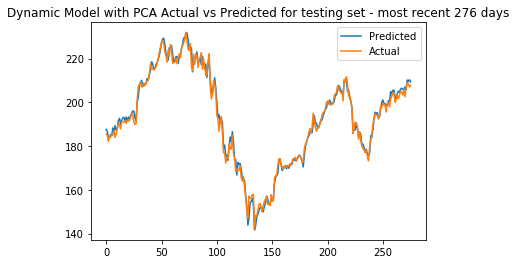

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Dynamic Model: MSE of testing data-  5.40458648730663


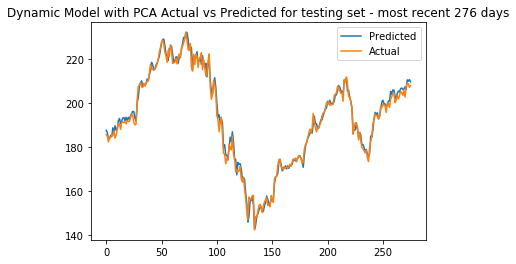

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Dynamic Model: MSE of testing data-  5.385869666939571


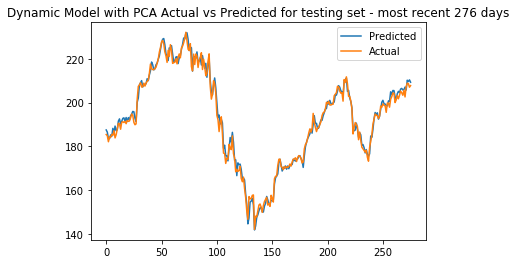

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)
Dynamic Model: MSE of testing data-  7.208138880434785


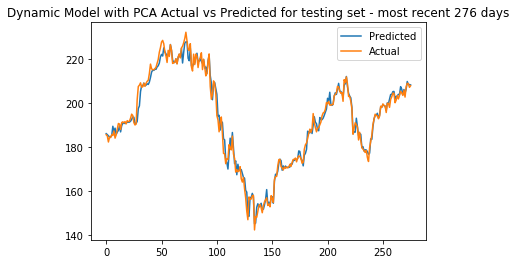

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Dynamic Model: MSE of testing data-  7.004023768115937


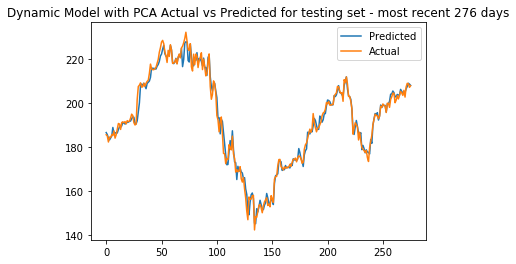

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)
Dynamic Model: MSE of testing data-  13.955242185752304


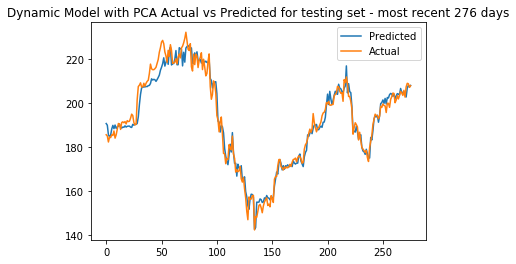

,Mean Squared Error
Linear,5.412669
Ridge,5.404586
Lasso,5.385870
Bagging,7.208139
RandomForest,7.004024
AdaBoost,13.955242


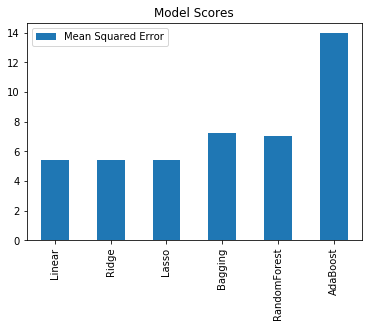

In [24]:

lets_try(X_train, y_train, X_test, y_test)